In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

A simple Parallel Workflow without LLM

In input we are getting:

- runs
- balls
- 4s
- 6s

And based on the input given we have to get:

- Strike Rate
- Runs in boundary
- Ball per boundary

The above 3 values can be easily calculated parallely cause they are not depend on each others data


In [19]:
class BatsManState(TypedDict):
    # Input attributes
    runs: int
    balls: int
    number_4s: int
    number_6s: int

    # Output-> Calculate attributes
    strike_rate: float
    bound_per_ball: float
    boundary_percent: float
    summary: str

In [20]:
graph = StateGraph(BatsManState)

In [ ]:
def calculate_sr(state: BatsManState) -> BatsManState:
    # To calculate strike rate we divide the runs made by 100

    sr = (state["runs"] / state["balls"]) * 100

    state["strike_rate"] = sr

    return state

In [22]:
def calculate_boundary_per_ball(state: BatsManState) -> BatsManState:
    # Number of balls divide by number of 4s and 6s

    bpb = state["balls"] / (state["number_4s"] + state["number_6s"])

    state["bound_per_ball"] = bpb

    return state

In [23]:
def calculate_boundary_percent(state: BatsManState) -> BatsManState:
    # Total runs with 4s and 6s divide by total runs

    boundary_percent = (
        ((state["number_4s"] * 4) + (state["number_6s"] * 6)) / state["runs"]
    ) * 100

    state["boundary_percent"] = boundary_percent

    return state

In [24]:
def summary(state: BatsManState) -> BatsManState:
    summary = f""" 
    
    Strike rate = {state["strike_rate"]}\n
    Boundary Per Ball = {state["bound_per_ball"]}\n
    Boundary Percent = {state["boundary_percent"]}\n"""

    state["summary"] = summary

    return state

In [25]:
# Add nodes

graph.add_node("get_strike_rate", calculate_sr)
graph.add_node("get_boundaryPerBall", calculate_boundary_per_ball)
graph.add_node("get_boundaryPerc", calculate_boundary_percent)
graph.add_node("get_summary", summary)

In [26]:
# Add edges

# Parallel
graph.add_edge(START, "get_strike_rate")
graph.add_edge(START, "get_boundaryPerBall")
graph.add_edge(START, "get_boundaryPerc")

# Aggregation
graph.add_edge("get_strike_rate", "get_summary")
graph.add_edge("get_boundaryPerBall", "get_summary")
graph.add_edge("get_boundaryPerc", "get_summary")

# Last Result
graph.add_edge("get_summary", END)

In [27]:
# Compile and Check
workflow = graph.compile()

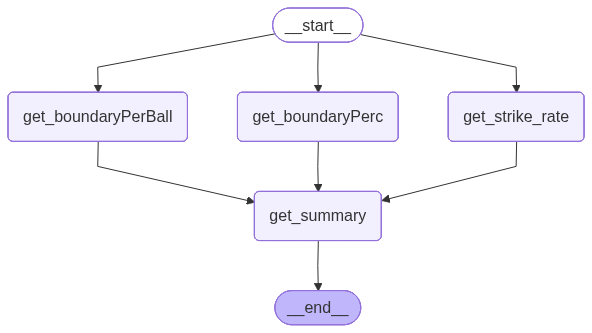

In [28]:
workflow

In [29]:
first_batsman = {
    "runs": 120,
    "balls": 50,
    "number_4s": 14,
    "number_6s": 8,
}

In [30]:
workflow.invoke(first_batsman)

InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

> Now the problem is All the nodes are returning complete state again which is causing errors because everyone is sending same key and value.

> Thus it thinks that enitre state is changing so we need to tell the node that which state we need to work on at a particular state.

> Here we will use the concept of Reducer to Avoid this Simultaneous change. The solution is Rather than sending the entire state we will only return the state which we are working on


In [40]:
def calculate_sr(state: BatsManState) -> BatsManState:
    sr = (state["runs"] / state["balls"]) * 100

    return {"strike_rate": sr}

In [32]:
def calculate_boundary_per_ball(state: BatsManState) -> BatsManState:
    # Number of balls divide by number of 4s and 6s

    bpb = state["balls"] / (state["number_4s"] + state["number_6s"])

    return {"bound_per_ball": bpb}


In [33]:
def calculate_boundary_percent(state: BatsManState) -> BatsManState:
    # Total runs with 4s and 6s divide by total runs

    boundary_percent = (
        ((state["number_4s"] * 4) + (state["number_6s"] * 6)) / state["runs"]
    ) * 100

    return {"boundary_percent": boundary_percent}

In [34]:
def summary(state: BatsManState) -> BatsManState:
    summary = f""" 
    
    Strike rate = {state["strike_rate"]}\n
    Boundary Per Ball = {state["bound_per_ball"]}\n
    Boundary Percent = {state["boundary_percent"]}\n"""

    return {"summary": summary}

This technique is Called **Partial Update**.

Rather than changing entire state we are Updating Concerning Values of the State at particular Node.


In [42]:
graph2 = StateGraph(BatsManState)

In [43]:
# Add nodes

graph2.add_node("get_strike_rate", calculate_sr)
graph2.add_node("get_boundaryPerBall", calculate_boundary_per_ball)
graph2.add_node("get_boundaryPerc", calculate_boundary_percent)
graph2.add_node("get_summary", summary)

In [44]:
# Add edges

# Parallel
graph2.add_edge(START, "get_strike_rate")
graph2.add_edge(START, "get_boundaryPerBall")
graph2.add_edge(START, "get_boundaryPerc")

# Agg2regation
graph2.add_edge("get_strike_rate", "get_summary")
graph2.add_edge("get_boundaryPerBall", "get_summary")
graph2.add_edge("get_boundaryPerc", "get_summary")

# Las2t Result
graph2.add_edge("get_summary", END)

In [45]:
workflow2 = graph2.compile()

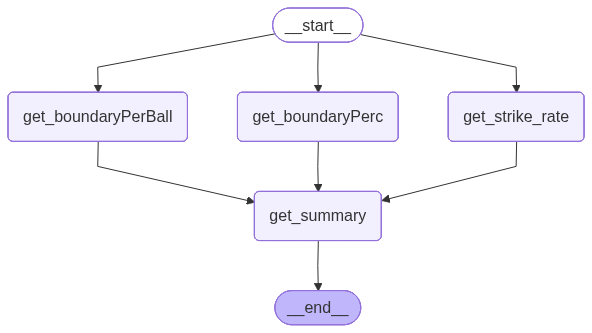

In [46]:
workflow2

In [47]:
second_batsman = {
    "runs": 120,
    "balls": 50,
    "number_4s": 14,
    "number_6s": 8,
}

In [48]:
workflow2.invoke(second_batsman)

{'runs': 120,
 'balls': 50,
 'number_4s': 14,
 'number_6s': 8,
 'strike_rate': 240.0,
 'bound_per_ball': 2.272727272727273,
 'boundary_percent': 86.66666666666667,
 'summary': ' \n\n    Strike rate = 240.0\n\n    Boundary Per Ball = 2.272727272727273\n\n    Boundary Percent = 86.66666666666667\n'}

The question is Which One to Use.

The Partial State Update is Better Approach Because it works Every Where
